Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.44      0.52        27
           1       0.75      0.87      0.80        52

    accuracy                           0.72        79
   macro avg       0.69      0.65      0.66        79
weighted avg       0.71      0.72      0.71        79



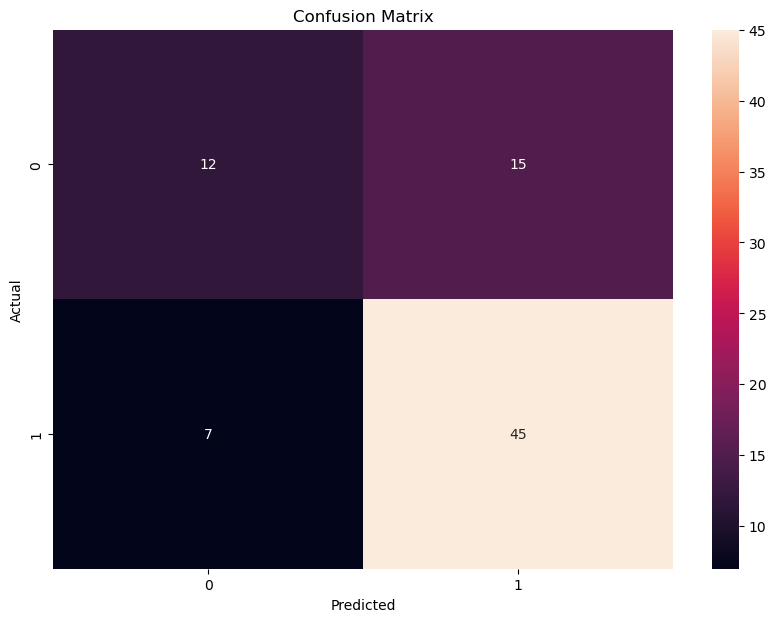

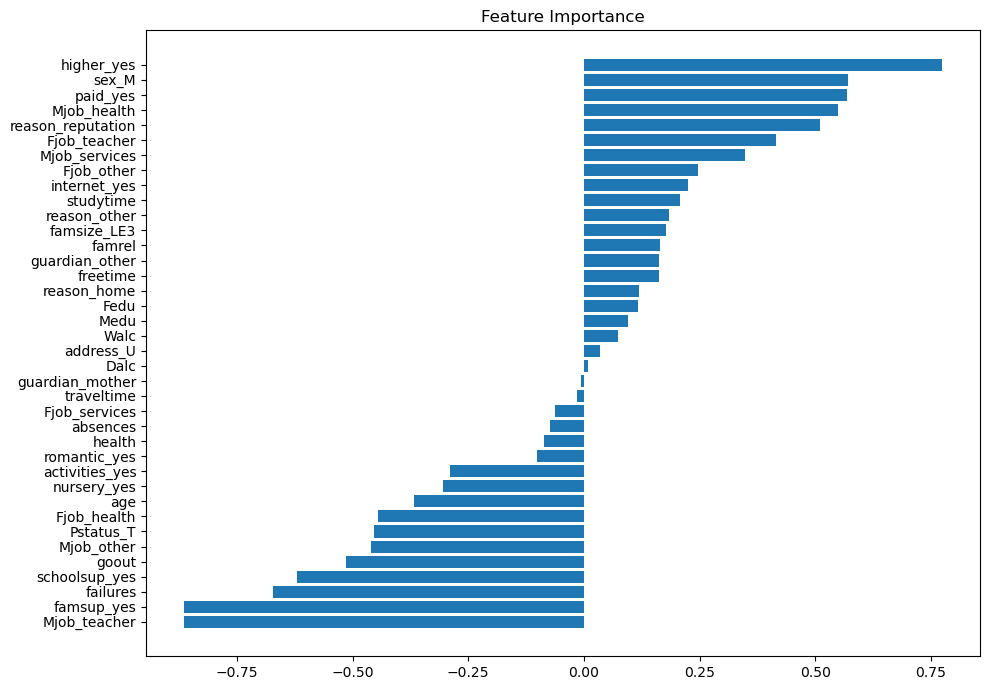


Top 5 most important features:
Mjob_teacher: -0.8642
famsup_yes: -0.8637
higher_yes: 0.7737
failures: -0.6719
schoolsup_yes: -0.6205


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

RANDOM_STATE = 42
TEST_SIZE = 0.2
FIGURE_SIZE = (10, 7)

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, sep=';')
    df['pass'] = (df['G3'] >= 10).astype(int)
    return df

def split_features_and_target(df, features):
    X = df[features]
    y = df['pass']
    return train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

def create_preprocessor(numeric_features, categorical_features):
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])

def create_pipeline(preprocessor):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=RANDOM_STATE))
    ])

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=FIGURE_SIZE)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix.png')
    plt.show()
    plt.close()

def plot_feature_importance(clf, feature_names):
    coefficients = clf.named_steps['classifier'].coef_[0]
    sorted_idx = np.argsort(coefficients)
    plt.figure(figsize=FIGURE_SIZE)
    plt.barh(range(len(sorted_idx)), coefficients[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    plt.close()

def print_top_features(coefficients, feature_names, n=5):
    top_n = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)[:n]
    print(f"\nTop {n} most important features:")
    for coef, feat in top_n:
        print(f"{feat}: {coef:.4f}")

def main():
    df = load_and_preprocess_data('student-mat.csv')

    features = ['age', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 
                'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 
                'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    
    numeric_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    categorical_features = [f for f in features if f not in numeric_features]

    X_train, X_test, y_train, y_test = split_features_and_target(df, features)

    preprocessor = create_preprocessor(numeric_features, categorical_features)
    clf = create_pipeline(preprocessor)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred)

    feature_names = (numeric_features + 
                     clf.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .get_feature_names_out(categorical_features).tolist())
    coefficients = clf.named_steps['classifier'].coef_[0]
    
    plot_feature_importance(clf, feature_names)
    print_top_features(coefficients, feature_names)

if __name__ == "__main__":
    main()